In [130]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
from imageio import imread
import numpy as np
import os
from os.path import join
from scripts.CNN.train_interactions import COLUMNS, match_pred_to_gt, model
import pandas as pd
from scripts.CNN.interactions_results import toarray, tostruct
import warnings
pd.set_option('precision', 2)

In [77]:
DATA_DIR = '/home/matej/prace/ferda/data/interactions/1801_1k_36rot_single'
EXPERIMENT_DIR = '/home/matej/prace/ferda/experiments/180104_0142_single'
SUB_EXPERIMENT = 0.857142857143

In [117]:
y_test = pd.read_csv(join(DATA_DIR, 'test.csv'))    

with h5py.File(join(EXPERIMENT_DIR, str(SUB_EXPERIMENT), 'predictions.h5'), 'r') as hf:
    pred = hf['data'][:]
    pred_df = pd.DataFrame(tostruct(pred))
    
loss_alpha_batch = pd.read_csv(join(EXPERIMENT_DIR, 'results.csv'))    

n_objects = pred_df.shape[1] / len(COLUMNS)
assert pred_df.shape[1] % len(COLUMNS) == 0

In [118]:
for i in range(n_objects):
    y_test['%d_angle_deg' % i] *= -1

In [47]:
loss_alpha_batch[loss_alpha_batch['loss_alpha'].round(4) == round(SUB_EXPERIMENT, 4)]

,Unnamed: 0,xy MAE,angle MAE,loss_alpha
12,12,3.68,3.08,0.86


In [49]:
loss_alpha_batch['xy MAE'].iloc[-1] = np.nan
xy = loss_alpha_batch['xy MAE']
loss_alpha_batch['xy MAE norm'] = (xy - xy.mean()) / xy.std()
#loss_alpha_batch['angle MAE'].iloc[0] = np.nan
angle = loss_alpha_batch['angle MAE']
loss_alpha_batch['angle MAE norm'] = (angle - angle.mean()) / angle.std()
loss_alpha_batch['sum norm'] = loss_alpha_batch['angle MAE norm'] + loss_alpha_batch['xy MAE norm']
loss_alpha_batch['alpha sum norm'] = loss_alpha_batch['angle MAE norm'] * (1 - loss_alpha_batch['loss_alpha']) + \
                                     loss_alpha_batch['xy MAE norm'] * loss_alpha_batch['loss_alpha']

In [50]:
# ax = loss_alpha_batch.plot('loss_alpha', ['xy MAE norm', 'angle MAE norm', 'alpha sum norm'], 
#                            title='normalized mean absolute errors')
# ax.legend(['xy', 'angle', 'alpha weighted sum'])
# ax.set_xlabel('alpha')

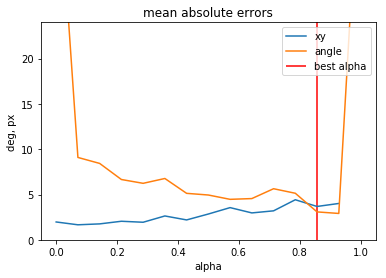

In [51]:
ax = loss_alpha_batch.plot('loss_alpha', ['xy MAE', 'angle MAE'], title='mean absolute errors')
ax.set_ylabel('deg, px')
ax.set_xlabel('alpha')
ax.set_ylim(0, 24)
ax.vlines(SUB_EXPERIMENT, ax.get_ylim()[0], ax.get_ylim()[1],
          'r')
ax.legend(['xy', 'angle', 'best alpha'])

# Predictions

In [52]:
pred_df.describe()

,0_x,0_y,0_major,0_minor,0_angle_deg,0_dx,0_dy
count,3600.00,3600.00,3600.00,3600.00,3600.00,3600.00,3600.00
mean,99.65,99.68,69.49,31.89,24.25,-35.34,60.72
std,10.32,10.26,24.59,41.09,51.26,28.04,35.04
min,72.99,76.83,23.23,-54.60,-78.86,-101.39,-11.22
25%,90.79,90.59,50.37,2.43,-19.56,-55.89,35.62
50%,99.83,100.00,65.83,22.38,20.79,-41.20,48.62
75%,108.92,108.43,86.19,59.85,68.57,-17.52,81.46
max,121.63,124.33,150.65,153.12,117.92,36.09,164.99


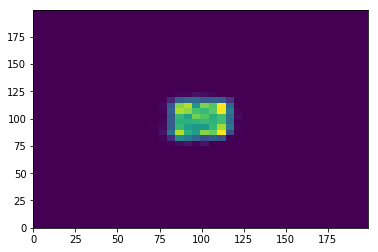

In [70]:
for i in range(n_objects):
    _ = plt.hist2d(pred_df['%d_x' % i], pred_df['%d_y' % i], bins=40, range=((0, 199), (0, 199)))

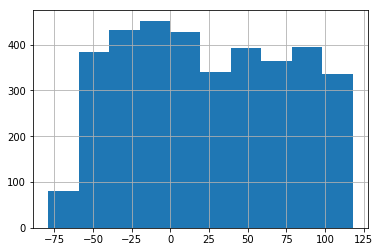

In [71]:
for i in range(n_objects):
    pred_df['%d_angle_deg' % i].hist()

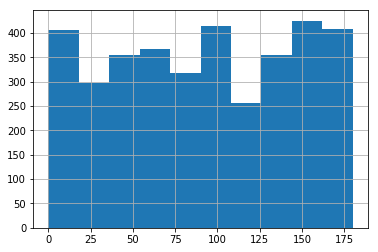

In [72]:
for i in range(n_objects):
    (pred_df['%d_angle_deg' % i] % 180).hist()

# Prediction Errors

In [119]:
PRED_COLUMNS = ['x', 'y', 'major', 'minor', 'angle_deg']
columns = []
for i in range(n_objects):
    columns.extend(['%d_%s' % (i, c) for c in PRED_COLUMNS])

xy, angle, indices = match_pred_to_gt(pred_df[columns].values, y_test[columns].values, np)
if n_objects == 1:
    xy_errors = xy
    angle_errors = angle
elif n_objects == 2:
    xy_errors = (xy[indices[:, 0], indices[:, 1]])
    angle_errors = (angle[indices[:, 0], indices[:, 1]])
else:
    assert False, 'not implemented'

# swap = indices[:, 0] == 1
# pred_swapped = pred.copy()
# pred_swapped[swap, :5], pred_swapped[swap, 5:] = pred_swapped[swap, 5:], pred_swapped[swap, :5]

In [121]:
df = pd.DataFrame.from_items([('xy (px)', [xy_errors.mean()]), 
                              ('angle (deg)', angle_errors.mean()),])
df.style.set_caption('MAE')
df

,xy (px),angle (deg)
0,3.68,3.08


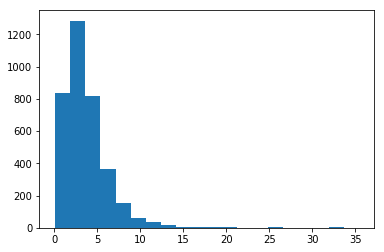

In [124]:
_  = plt.hist(xy_errors, 20)

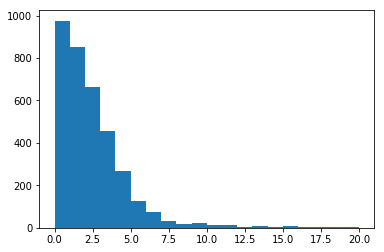

In [128]:
_ = plt.hist(angle_errors, 20, range=(0, 20))

# Model

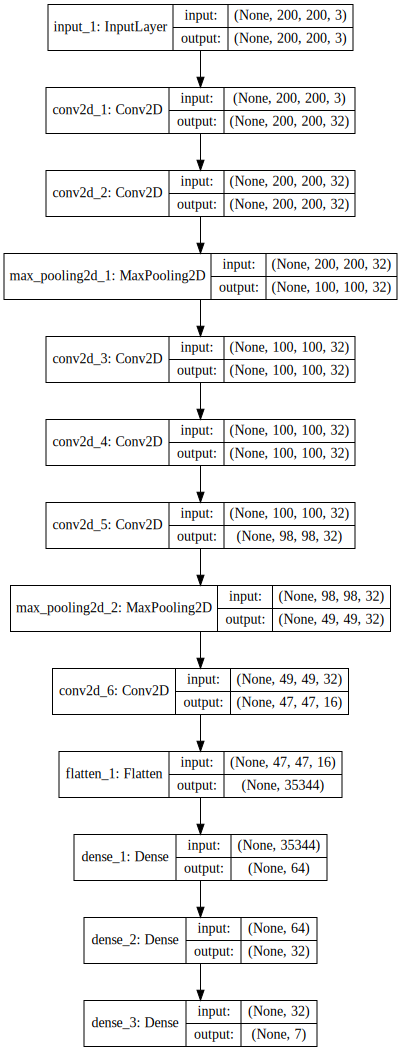

In [131]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model(), show_shapes=True).create(prog='dot', format='svg'))

In [83]:
# SVG(model_to_dot(model.get_layer('model_1'), show_shapes=True).create(prog='dot', format='svg'))